In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy.sparse import coo_array
import pandas as pd

from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve

In [ ]:
import torch 

In [176]:
import CurvilinearFEM_Trial_2D as FEM

In [2]:
#Definition of mechanical properties of the continuum
Youngs_modulus=200*10**9#Pa
Poisson_Ratio=0.3#0.3# No units
Rho=7850#kg/m^3
Lame_mu=Youngs_modulus*0.5/(1+Poisson_Ratio)#Pa
Lame_lambda=Youngs_modulus*Poisson_Ratio/(1+Poisson_Ratio)/(1-2*Poisson_Ratio)#Pa

force=Rho*np.array([0,-9.81])

In [32]:
x=torch.tensor([0.2,0.5],dtype=torch.float32,requires_grad=True)
y=torch.zeros(2)
y[0]=torch.pow(x[0],3)
y[1]=torch.pow(x[1],2)

print(f'{y=}')
g = torch.autograd.grad(y[0], x, create_graph=True)
print(f'{g=}'  )
g[0].backward(torch.FloatTensor([1, 0]),retain_graph=True)
print(f'{x.grad=}' )
x.grad.data.zero_()
g[0].backward(torch.FloatTensor([0, 1]),retain_graph=True)
print(x.grad)
x.grad.data.zero_()

g = torch.autograd.grad(y[1], x, create_graph=True)
#print(g)
g[0].backward(torch.FloatTensor([1, 0]),retain_graph=True)
print(x.grad)
x.grad.data.zero_()
g[0].backward(torch.FloatTensor([0, 1]),retain_graph=True)
print(x.grad)
x.grad.data.zero_()


jacobian=torch.zeros(2,2)

y.backward(torch.FloatTensor([1, 0]),retain_graph=True)
jacobian[:,0] = x.grad.data
x.grad.data.zero_()

y.backward(torch.FloatTensor([0, 1]), retain_graph=True)
jacobian[:,1] = x.grad.data
x.grad.data.zero_()

print(jacobian)



y=tensor([0.0080, 0.2500], grad_fn=<CopySlices>)
g=(tensor([0.1200, 0.0000], grad_fn=<AddBackward0>),)
x.grad=tensor([1.2000, 0.0000])
tensor([0., 0.])
tensor([0., 0.])
tensor([0., 2.])
tensor([[0.1200, 0.0000],
        [0.0000, 1.0000]])


In [40]:
def get_jacob_christoffel(x:torch.Tensor,f):
    """
    Compute the jacobian and christoffel symbols of the function f at x
    """
    m=len(x)
    y_temp=f(x) # Create the y instances in a list
    assert type(y_temp)==list
    n=len(y_temp)

    # Allocate the y instances in a tensor
    y=torch.zeros(n,dtype=torch.float32)
    for i in range(n):
        y[i]=y_temp[i]
    assert n==m

    # collect the jacobian and christoffel symbols
    jacobian=torch.zeros(n,m)
    gamma=torch.zeros(n,m,m)
    for i in range(n):
        # collect jacobian (1st order derivatives)
        y[i].backward(retain_graph=True)
        jacobian[i,:]=x.grad.data
        x.grad.data.zero_()
        
        # collect christoffel symbols (2nd order derivatives)
        g = torch.autograd.grad(y[i], x, create_graph=True)
        for j in range(m):
            v_temp=[0]*m
            v_temp[j]=1
            g[0].backward(torch.FloatTensor(v_temp),retain_graph=True)
            gamma[i,j,:]=x.grad.data
            x.grad.data.zero_()
    return jacobian,gamma

In [44]:
J,gamma=get_jacob_christoffel(torch.tensor([0.2,0.5],dtype=torch.float32,requires_grad=True),
                      lambda x:[torch.pow(x[0],3),torch.pow(x[1],2)])
print(f'{J= }')
print(f'{gamma= } ')

J= tensor([[0.1200, 0.0000],
        [0.0000, 1.0000]])
gamma= tensor([[[1.2000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 2.0000]]]) 


In [7]:
class custom_function_2d:
    def __init__(self, 
                 function, # (s,t)=f(x,y)
                 prime, # [[ds/dx,ds/dy],[dt/dx,dt/dy]]
                 inverse, # (x,y)=f_inv(s,t)
                 Christoffel_symbols, # Chrstoffel symbols ([[[Γ^s_ss,Γ^t_ss],[Γ^s_st,Γ^t_st]],[[Γ^s_ts,Γ^t_ts],[Γ^s_tt,Γ^t_tt]]])
                 basis_vec,
                 name : str=""):
        for st in [(0,0),(0,1),(1,0),(1,1)]:
            f=function(st)
            inv=inverse(st)
            assert type(f) is np.ndarray, "Function must turn list."
            assert len(f) ==2, "Function must turn list of size 2."
            assert type(inv) is np.ndarray, "The inverse must turn tuple."
            assert len(inv) ==2, "The inverse must turn tuple of size 2."
            for i in range(2):
                assert f[i]==st[i], f"Function must be {st} at {st}, but it's turning {f}."
                assert inv[i]==st[i], f"The inverse must be {st} at {st}, but it's turning {inv}."
        for st in [(0,0),(0,1),(1,0),(1,1)]:
            p=prime(st)
            assert type(p) is np.ndarray, "The prime must turn 2x2 matrix (list of list)"
            assert len(p)==2, "The prime must turn 2x2 matrix (list of list)"
            assert len(p[0])==2, "The prime must turn 2x2 matrix (list of list)"
        for i in np.linspace(0,1,5):
            for j in np.linspace(0,1,5):
                f_inv=inverse(function((i,j)))
                assert (f_inv[0]-i)**2<0.001, "The inverse is not correct"
                assert (f_inv[1]-j)**2<0.001, "The inverse is not correct"
        
        self.function = function
        self.prime = prime
        self.inverse = inverse
        self.Christoffel_symbols = Christoffel_symbols
        self.basis_vec = basis_vec
        self.name = name

In [8]:
alpha=custom_function_2d(lambda xy:  np.array(xy),
                          lambda xy:  np.array([[1,0],[0,1]]), # prime : [[∂s/∂x, ∂t/∂x],[∂s/∂y, ∂t/∂y]]
                          lambda st:  np.array( st), 
                          lambda st: np.array([[[0,0],[0,0]],[[0,0],[0,0]]]),
                          #lambda xy: np.array([[1,0],[0,1]]),
                          "identity")
# alpha=custom_function_2d(lambda xy:  np.array([xy[0],xy[1]**2]),
#                           lambda xy:  np.array([[1,0],[0,2*xy[1]]]), # prime : [[∂s/∂x, ∂t/∂x],[∂s/∂y, ∂t/∂y]]
#                           lambda st:  np.array( [st[0],np.sqrt(st[1])]), 
#                           lambda st: np.array([[[0,0],[0,0]],[[0,0],[0,-0.25*st[1]**(-1.5)]]]),
#                             #lambda st: np.array([[1,0],[0,0.5/np.sqrt(st[1])]]),
#                           "Xlinear-Ysquare")
alpha=custom_function_2d(lambda xy:  np.array([xy[0],((xy[1]+1)**2-1)/3]),
                          lambda xy:  np.array([[1,0],[0,2*(xy[1]+1)/3]]), # prime : [[∂s/∂x, ∂t/∂x],[∂s/∂y, ∂t/∂y]]
                          lambda st:  np.array( [st[0],np.sqrt(st[1]*3+1)-1]), 
                          lambda st: np.array([[[0,0],[0,0]],[[0,0],[0,-9/4*(3*st[1]+1)**(-1.5)]]]),
                            #lambda st: np.array([[1,0],[0,0.5/np.sqrt(st[1])]]),
                          "Xlinear-Ysquare")
# alpha=custom_function_2d(lambda xy:  np.array([xy[0],np.sqrt(xy[1])]),
#                           lambda xy:  np.array([[1,0],[0,0.5/np.sqrt(xy[1])]]), # prime : [[∂s/∂x, ∂t/∂x],[∂s/∂y, ∂t/∂y]]
#                           lambda st:  np.array( [st[0],st[1]**2]), 
#                           lambda st: np.array([[[0,0],[0,0]],[[0,0],[0,2]]]),
#                           "Xlinear-Ysqrt")
alpha=custom_function_2d(lambda xy:  np.array([((xy[0]+1)**2-1)/3,((xy[1]+1)**2-1)/3]),
                          lambda xy:  np.array([[2*(xy[0]+1)/3,0],[0,2*(xy[1]+1)/3]]), # prime : [[∂s/∂x, ∂t/∂x],[∂s/∂y, ∂t/∂y]]
                          lambda st:  np.array( [np.sqrt(st[0]*3+1)-1,np.sqrt(st[1]*3+1)-1]), 
                          lambda st: np.array([[[-9/4*(3*st[0]+1)**(-1.5),0],[0,0]],[[0,0],[0,-9/4*(3*st[1]+1)**(-1.5)]]]),
                            #lambda st: np.array([[1,0],[0,0.5/np.sqrt(st[1])]]),
                          "Xsquare-Ysquare")

In [9]:
# Definition of mesh on xy coordinates.
W, H = 1.0, 1.0
Nx_divisions = 15
Ny_divisions = 15

Nx = Nx_divisions + 1
Ny = Ny_divisions + 1
d_x = W/Nx_divisions
d_y = H/Ny_divisions

N_nodes=Nx*Ny
# N_nodes_dummy=Nx_divisions*Ny
N_ele=Ny_divisions*Nx_divisions

xy_coor=np.empty((N_nodes,2),float)
cny=np.empty((N_ele,4),int)


for i_y in range(Ny):
    xy_coor[i_y*Nx:(i_y+1)*Nx,1]=i_y*d_y

for i_x in range(Nx):
    xy_coor[i_x::Nx,0]=i_x*d_x

for i_y in range(Ny_divisions):
    for i_x in range(Nx_divisions):
        i_ele=i_x+i_y*Nx_divisions
        cny[i_ele,0]=i_x   + i_y * Nx
        cny[i_ele,1]=i_x+1 + i_y * Nx
        cny[i_ele,2]=i_x   + (i_y+1) * Nx
        cny[i_ele,3]=i_x+1 + (i_y+1) * Nx

        
cny_dummy=cny.copy()

for i_y in range(Ny_divisions):
    cny_dummy[(i_y+1)*Nx_divisions-1,1]=i_y * Nx
    cny_dummy[(i_y+1)*Nx_divisions-1,3]=(i_y+1) * Nx

st_coor=alpha.function(xy_coor.T).T

# Gauss points and weights
# https://en.wikipedia.org/wiki/Gaussian_quadrature
# gauss_points = (np.array([-np.sqrt(5+2*np.sqrt(10/7))/3,-np.sqrt(5-2*np.sqrt(10/7))/3, 0, 
#                               np.sqrt(5-2*np.sqrt(10/7))/3,np.sqrt(5+2*np.sqrt(10/7))/3])+1.0)*0.5
# gauss_weights = np.array([(322-13*np.sqrt(70))/900, (322+13*np.sqrt(70))/900, 128/225, 
#                           (322+13*np.sqrt(70))/900, (322-13*np.sqrt(70))/900])*0.5
gauss_points = (np.array([-np.sqrt(3/5), 0,np.sqrt(3/5)])+1.0)*0.5
gauss_weights = np.array([5/9, 8/9, 5/9])*0.5
N_gauss_points = gauss_points.size

# Shape functions : s,t\in[0,1]
N_nodes_e=4
N=lambda zeta,eta: np.array([(1-zeta)*(1-eta),  zeta*(1-eta),(1-zeta)*eta,  zeta*eta])
N_derivatives=lambda zeta,eta: np.array( [ [eta-1,zeta-1],[1-eta,-zeta],[-eta,1-zeta],[eta,zeta]])


In [10]:
K=np.zeros((N_nodes*2,N_nodes*2))
f_vector=np.zeros(N_nodes*2)

K_row=np.empty((N_ele*(N_nodes_e*2)**2),dtype=int)
K_col=np.empty((N_ele*(N_nodes_e*2)**2),dtype=int)
K_values=np.empty((N_ele*(N_nodes_e*2)**2),dtype=float)

for i_y in range(Ny_divisions):
    for i_x in range(Nx_divisions):
        i_ele=i_y*Nx_divisions+i_x

        # Element 
        node_ids= cny[i_ele]
        node_dummy_ids= cny_dummy[i_ele]
        
        # Element coordinates
        node_coordinates = st_coor[node_ids]

        
        K_e = np.zeros((N_nodes_e*2,N_nodes_e*2))
        f_e = np.zeros(N_nodes_e*2)
        for i_zeta_gauss in range(N_gauss_points):
            for i_eta_gauss in range(N_gauss_points):
                zeta_gauss = gauss_points[i_zeta_gauss]
                eta_gauss = gauss_points[i_eta_gauss]

                N_st=N(zeta_gauss,eta_gauss)

                s=(node_coordinates[:,0]*N_st).sum()
                t=(node_coordinates[:,1]*N_st).sum()

                #prepare collection of variables
                K_temp = np.zeros((N_nodes_e*2,N_nodes_e*2))
                F_temp = np.zeros(N_nodes_e*2)

                # Jacobian # 
                J = alpha.prime(alpha.inverse((s,t))) # J^st_xy
                basis_vector_st = np.linalg.inv(J) # e_s,e_t
                #print(basis_vector_st)
                inv_det_J=np.linalg.det(basis_vector_st)
                
                #Christoffel symbols
                Gamma = alpha.Christoffel_symbols((s,t))

                #N_local
                N_derivatives_st=N_derivatives(zeta_gauss,eta_gauss)
                J2=np.linalg.inv(N_derivatives_st.T@node_coordinates)
                
                #First, gather the epsilons.
                epsilon_v = np.zeros((N_nodes_e*2,2,2))
                for i_node in range(N_nodes_e):
                    for j_index in range(2):# j_index = 0(s), 1(t)
                        #                 N_i * Gamma^l_jk (k=s,t, l=x,y)
                        epsilon_v_temp = N_st[i_node] * Gamma[j_index,:,:]
                        #         J^(zeta,eta)_(s,t) [ ∂N_i/∂zeta, ∂N_i/∂eta].T @ [(e_j)x, (e_j)y]
                        epsilon_v_temp += J2@N_derivatives_st[i_node,:,None] @ basis_vector_st[j_index,None,:]
                        epsilon_v_temp = J@epsilon_v_temp
                        epsilon_v[i_node*2+j_index,:,:] = (epsilon_v_temp+epsilon_v_temp.T)*0.5
                
                      
                sigma_u = np.zeros((N_nodes_e*2,2,2))
                for i_node in range(N_nodes_e):
                    for j_index in range(2):#j_index=0(s),1(t)
                        sigma_u[i_node*2+j_index,:,:] = \
                            Lame_lambda*np.trace(epsilon_v[i_node*2+j_index,:,:])*np.eye(2)+\
                            2*Lame_mu*epsilon_v[i_node*2+j_index,:,:]
                
                for i_node in range(N_nodes_e*2):
                    for i_node_2 in range(N_nodes_e*2):
                        K_temp[i_node,i_node_2] = np.sum(sigma_u[i_node,:,:]*epsilon_v[i_node_2,:,:])
                K_e += K_temp*gauss_weights[i_zeta_gauss]*gauss_weights[i_eta_gauss]*d_x*d_y#*inv_det_J
             
                force_st = basis_vector_st @ force# 2x2, 2x1 -> 2x1 
                for i_node in range(N_nodes_e):
                    F_temp[i_node*2:i_node*2+2] = N_st[i_node]*force_st
                    # for j_index in range(2):
                    #     F_temp[i_node*2+j_index] = N_st[i_node]*force_st[j_index]
                f_e += F_temp*gauss_weights[i_zeta_gauss]*gauss_weights[i_eta_gauss]*d_x*d_y#*inv_det_J
                
        indeces=np.zeros(N_nodes_e*2,dtype=int)
        indeces[0:N_nodes_e*2:2]=node_ids*2
        indeces[1:N_nodes_e*2:2]=node_ids*2+1
        indeces[0:N_nodes_e*2:2]=node_dummy_ids*2
        indeces[1:N_nodes_e*2:2]=node_dummy_ids*2+1

        f_vector[indeces]+=f_e

        i_ele_start=(i_x+i_y*Nx_divisions)*(N_nodes_e*2)**2
        for i in range(N_nodes_e*2):
            for j in range(N_nodes_e*2):
                K_values[i_ele_start+i*(N_nodes_e*2)+j] = K_e[i,j]
                K_row[i_ele_start+i*(N_nodes_e*2)+j]    = indeces[i]
                K_col[i_ele_start+i*(N_nodes_e*2)+j]    = indeces[j]

K=coo_matrix((K_values, (K_row, K_col)), shape=(N_nodes*2, N_nodes*2)).tocsr()
#K,f_vector

In [11]:
N_dofs=N_nodes*2

#Apply boundary conditions
#u_known_index=np.zeros(Nt*2,dtype=int)
u_value=np.zeros(N_dofs,dtype=float)
u_BC=np.zeros(N_dofs,dtype=int)

for i in range(1,Ny):
    # Fix the left side (fix x displacement)
    u_value[i*Nx*2]=0
    u_BC[i*Nx*2]=-1

    #Fix the right side (fix x displacement)
    u_value[(i+1)*Nx*2-2]=0
    u_BC[(i+1)*Nx*2-2]=-1

# Fix the bottom side (fix x and y displacement)
for i in range(Nx):
    u_value[i*2]=0
    u_value[i*2+1]=0
    u_BC[i*2]=-1
    u_BC[i*2+1]=-1

# Define cyclic boundary

for i in range(1,Ny):
    #Fix the right side (fix y displacement as cyclic boundary)
    u_BC[(i+1)*Nx*2-1]=-1

N_known=-np.sum(u_BC)
N_unknown=N_dofs-N_known

count=0
for i in range(N_dofs):
    if u_BC[i]!=-1:
        u_BC[i]=count
        count+=1


In [12]:
#A=np.zeros((N_unknown, N_unknown))

# A_row=np.empty(N_unknown, dtype=int)
# A_col=np.empty(N_unknown, dtype=int)
# A_values=np.empty(N_unknown, dtype=float)
A_row=[]
A_col=[]
A_values=[]

b=np.zeros(N_unknown)

for ind in range(N_dofs):
    i=u_BC[ind]
    if i==-1:
        continue
    b[i]=f_vector[ind]
    for ptr in range(K.indptr[ind],K.indptr[ind+1]):
        i2=K.indices[ptr]
        if u_BC[i2]!=-1:
            if K.data[ptr]==0.0:
                continue
            A_values.append(K.data[ptr])
            A_row.append(i)
            A_col.append(u_BC[i2])
        else:
            b[i]-=K.data[ptr]*u_value[i2]
    
A=coo_matrix((A_values, (A_row, A_col)), shape=(N_unknown, N_unknown)).tocsr()
u_unknown_value=spsolve(A,b)
#u_value=np.zeros(Ns*Nt*2)
#u_value[u_known_index]=u_known_value
u_value[u_BC!=-1]=u_unknown_value

# update boundary displacements
for i in range(1,Ny):
    #Fix the right side (fix y displacement as cyclic boundary)
    u_value[(i+1)*Nx*2-1]=u_value[(i)*Nx*2+1]
#u_value

In [13]:
f_analytical=lambda x,y: -1/(Lame_lambda+2*Lame_mu)*force[1]*(0.5*y**2-H*y)
u_analytical=np.zeros(N_dofs)
u_analytical[1::2]=f_analytical(xy_coor[:,0],xy_coor[:,1])
#u_analytical

In [14]:
# adjust the u_value depending the local basis vector.
e_basis_length=np.zeros((N_nodes,2))
for i in range(Ny) :
    for j in range(Nx):
        J=alpha.prime(xy_coor[i*Nx+j,:])
        e_basis_length[i*Nx+j,:]=np.linalg.norm(np.linalg.inv(J),axis=0)

u_value_xy=u_value*e_basis_length.flatten()

#u_value

In [15]:
SE=0.0
for i_y in range(Ny_divisions):
    for i_x in range(Nx_divisions):
        i_ele=i_y*Nx_divisions+i_x

        # Element 
        node_ids= cny[i_ele]
        
        # Element coordinates
        node_coordinates = st_coor[node_ids]

        e_basis=np.zeros((N_nodes_e,2,2))
        for i,node_id in enumerate(node_ids):
            e_basis[i,:,:]=np.linalg.inv(alpha.prime(xy_coor[node_id,:]))
        

        indeces=np.zeros(N_nodes_e*2,dtype=int)
        indeces[0:N_nodes_e*2:2]=node_ids*2
        indeces[1:N_nodes_e*2:2]=node_ids*2+1

        u_values_local=u_value[indeces].reshape((4,2))

        SE_local=0.0
        for i_zeta_gauss in range(N_gauss_points):
            for i_eta_gauss in range(N_gauss_points):
                zeta_gauss = gauss_points[i_zeta_gauss]
                eta_gauss = gauss_points[i_eta_gauss]

                N_st=N(zeta_gauss,eta_gauss)
                u_local=np.einsum('ij,i,ijk->k',u_values_local,N_st,e_basis)
                #print(u_local)

                s=(node_coordinates[:,0]*N_st).sum()
                t=(node_coordinates[:,1]*N_st).sum()
                xy=alpha.inverse((s,t))
                u_analytical_local=np.array([0,f_analytical(xy[0],xy[1])])
                #print(u_analytical_local)
                SE_local+=((u_local[0]-u_analytical_local[0])**2+(u_local[1]-u_analytical_local[1])**2)*gauss_weights[i_zeta_gauss]*gauss_weights[i_eta_gauss]
        SE+=SE_local*d_x*d_y

RMSE=np.sqrt(SE/(W*H))
RMSE

1.1481841953814845e-10

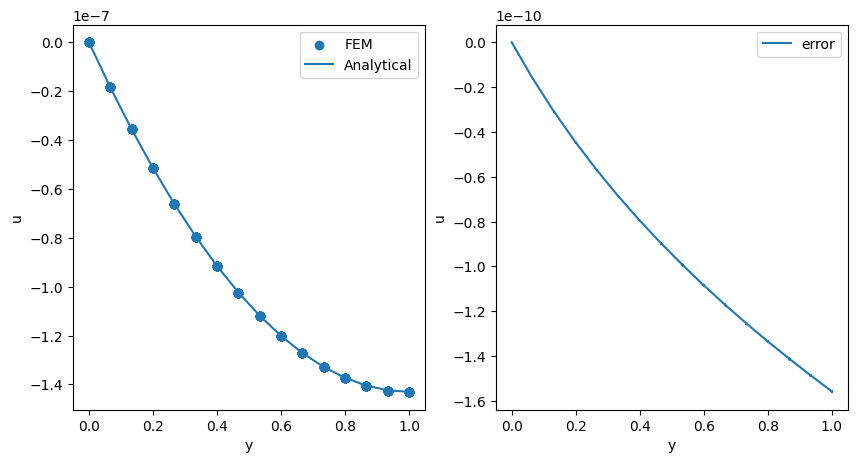

In [16]:
du=u_value_xy-u_analytical
# plot u_value and u_analytical
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(xy_coor[:,1],u_value_xy[1::2],label='FEM')
ax[0].plot(xy_coor[:,1],u_analytical[1::2],label='Analytical')
ax[0].set_xlabel('y')
ax[0].set_ylabel('u')
ax[0].legend()

# plot u_value and u_analytical
ax[1].plot(xy_coor[:,1],du[1::2],label='error')
ax[1].set_xlabel('y')
ax[1].set_ylabel('u')
ax[1].legend()
plt.show()


In [17]:
with open('output.vtu','w') as fw:
    fw.write("# vtk DataFile Version 2.0\nvtk\nASCII\nDATASET UNSTRUCTURED_GRID\n")
    
    fw.write(f"POINTS {Nx*Ny} float\n")
    for i in range(N_nodes):
        fw.write(f"{xy_coor[i,0]} {xy_coor[i,1]} 0.0\n")
    fw.write("\n")

    fw.write(f"CELLS {N_ele} {5*N_ele}\n")
    for i in range(N_ele):
        fw.write(f"4 {cny[i,0]} {cny[i,1]} {cny[i,2]} {cny[i,3]}\n")
    fw.write("\n")

    fw.write(f"CELL_TYPES {N_ele}\n")
    for i in range(N_ele):
        fw.write("8\n")
    fw.write("\n")
    fw.write(f"POINT_DATA {N_nodes}\n")
    fw.write("VECTORS displacement float\n")
    for i in range(N_nodes):
        fw.write(f"{u_value_xy[i*2]} {u_value_xy[i*2+1]} 0.0\n")
    # for i in range(Ny):
    #     for j in range(Nx):
    #         fw.write(f"{u_value[(j%Nx_divisions)*2+i*Nx_divisions*2]} {u_value[(j%Nx_divisions)*2+1+i*Nx_divisions*2]} 0.0\n")
        
    # for i in range(Ns*Nt):
    #     fw.write(f"{u_value[i*2]} {u_value[i*2+1]} 0.0\n")
    fw.write("\n")


  